## **SKENARIO 1: Klasifikasi VBNN - Feature Selection**

## **IMPORT LIBRARY**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
import time
from collections import namedtuple
from matplotlib.lines import Line2D
from scipy.spatial import Voronoi, voronoi_plot_2d

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

## **DATA LOADING**

In [3]:
# Load dan read data
url_train = "https://drive.google.com/uc?export=download&id=1mwBc1Xbdp5vezgcQLi-BWcsaVNxiqblv"
url_test = "https://drive.google.com/uc?export=download&id=1nSQr83pGwZQ-ShLgrDWH0AoPEi3E5FgF"
url_label = "https://drive.google.com/uc?export=download&id=169-NXQYAKyntsfhcEjzWc0oNB4dD4DkQ"

df_train = pd.read_csv(url_train)
df_test = pd.read_csv(url_test)
df_label = pd.read_csv(url_label)

In [4]:
# Menggabungkan fitur train dan label 
df = pd.concat([df_train, df_label], axis=1)
print(f"Dataset Loaded\nDimensi: {df.shape}")

Dataset Loaded
Dimensi: (3817, 17)


## **PREPROCESSING**

### - **Feature Engineering**

In [5]:
def feature_engineering(df_in):
    REF_YEAR = 2025
    REF_DATE = datetime(2025, 12, 31)

    df_out = df_in.copy()
    
    # 1. Fix Date Type
    df_out['tanggal_menjadi_anggota'] = pd.to_datetime(df_out['tanggal_menjadi_anggota'], errors='coerce')
    
    # 2. Feature: Umur
    df_out['umur'] = REF_YEAR - df_out['tahun_kelahiran']
    
    # 3. Feature: Lama Bergabung (Hari)
    df_out['lama_bergabung_hari'] = (REF_DATE - df_out['tanggal_menjadi_anggota']).dt.days
    
    # 4. Feature: Total Belanja
    col_belanja = ['belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue']
    df_out[col_belanja] = df_out[col_belanja].fillna(0)
    df_out['total_belanja'] = df_out[col_belanja].sum(axis=1)

    # 5. Rata-rata belanja per kategori
    df_out['avg_belanja'] = df_out['total_belanja'] / 4

    # 6. Rasio belanja protein
    df_out['rasio_protein'] = (
        df_out['belanja_daging'] + df_out['belanja_ikan']
    ) / (df_out['total_belanja'] + 1)
    
    # Drop kolom mentah
    df_out.drop(columns=['tahun_kelahiran', 'tanggal_menjadi_anggota'], inplace=True, errors='ignore')
    
    return df_out

df_eng = feature_engineering(df)
print(f"Feature Engineering Selesai\nDimensi: {df_eng.shape}")

Feature Engineering Selesai
Dimensi: (3817, 20)


### - **Data Cleaning**

In [6]:
# Ganti noise '5' dengan NaN agar dianggap missing value
df_clean = df_eng.copy()

cols_with_noise = ['pendidikan', 'status_pernikahan']
for col in cols_with_noise:
    df_clean[col] = df_clean[col].replace('5', np.nan)

In [7]:
# Memisahkan Fitur (X) dan Target (y)
target_col = 'jumlah_promosi'
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

In [8]:
# Melakukan Split data
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Split Done. \nTrain Shape: {X_train_raw.shape}, Val Shape: {X_val_raw.shape}")

Data Split Done. 
Train Shape: (3053, 19), Val Shape: (764, 19)


In [9]:
X_train_clean = X_train_raw.copy()
X_val_clean = X_val_raw.copy()

In [10]:
# Imputasi Missing Values

# Numeric (Median)
imputer_num = SimpleImputer(strategy='median')
X_train_clean[num_cols] = imputer_num.fit_transform(X_train_clean[num_cols])
X_val_clean[num_cols] = imputer_num.transform(X_val_clean[num_cols])

# Categorical (Mode)
imputer_cat = SimpleImputer(strategy='most_frequent')
X_train_clean[cat_cols] = imputer_cat.fit_transform(X_train_clean[cat_cols])
X_val_clean[cat_cols] = imputer_cat.transform(X_val_clean[cat_cols])


X_train_imp = pd.DataFrame(X_train_clean, columns=X_train_clean.columns, index=X_train_raw.index)
X_val_imp = pd.DataFrame(X_val_clean, columns=X_val_clean.columns, index=X_val_raw.index)

print("Missing Value Imputation Selesai")

Missing Value Imputation Selesai


In [11]:
X_train_imp.isna().sum()

pendidikan             0
status_pernikahan      0
pendapatan             0
jumlah_anak_balita     0
jumlah_anak_remaja     0
terakhir_belanja       0
belanja_buah           0
belanja_daging         0
belanja_ikan           0
belanja_kue            0
pembelian_diskon       0
pembelian_web          0
pembelian_toko         0
keluhan                0
umur                   0
lama_bergabung_hari    0
total_belanja          0
avg_belanja            0
rasio_protein          0
dtype: int64

In [12]:
X_val_imp.isna().sum()

pendidikan             0
status_pernikahan      0
pendapatan             0
jumlah_anak_balita     0
jumlah_anak_remaja     0
terakhir_belanja       0
belanja_buah           0
belanja_daging         0
belanja_ikan           0
belanja_kue            0
pembelian_diskon       0
pembelian_web          0
pembelian_toko         0
keluhan                0
umur                   0
lama_bergabung_hari    0
total_belanja          0
avg_belanja            0
rasio_protein          0
dtype: int64

### - **FEATURE TRANSFORMATION**

In [13]:
# Melakukan encoding
X_train_enc = X_train_imp.copy()
X_val_enc = X_val_imp.copy()

# Ordinal Mapping (Pendidikan)
education_map = {'SMP': 1, 'SMA': 2, 'Sarjana': 3, 'Magister': 4, 'Doktor': 5}
X_train_enc['pendidikan'] = X_train_enc['pendidikan'].map(education_map)
X_val_enc['pendidikan'] = X_val_enc['pendidikan'].map(education_map)

# One-Hot Encoding (Status Pernikahan)
X_train_enc = pd.get_dummies(X_train_enc, columns=['status_pernikahan'], prefix='status', dtype=int)
X_val_enc = pd.get_dummies(X_val_enc, columns=['status_pernikahan'], prefix='status', dtype=int)
X_val_enc = X_val_enc.reindex(columns=X_train_enc.columns, fill_value=0)

print("Encoding selesai")

Encoding selesai


In [14]:
# Handling Outliers 
X_train_out = X_train_enc.copy()
X_val_out = X_val_enc.copy()

def get_iqr_bounds(series, factor):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR

    return lower_bound, upper_bound


outlier_summary = []

num_cols = X_train_out.select_dtypes(include="number").columns.tolist()

for col in num_cols:
    mild_l, mild_u = get_iqr_bounds(X_train_out[col], 1.5)
    ext_l, ext_u = get_iqr_bounds(X_train_out[col], 3)
    vext_l, vext_u = get_iqr_bounds(X_train_out[col], 5)

    outlier_summary.append({
        "feature": col,
        "mild_outlier_pct (%)":
            ((X_train_out[col] < mild_l) | (X_train_out[col] > mild_u)).mean() * 100,
        "extreme_outlier_pct (%)":
            ((X_train_out[col] < ext_l) | (X_train_out[col] > ext_u)).mean() * 100,
        "very_extreme_outlier_pct (%)":
            ((X_train_out[col] < vext_l) | (X_train_out[col] > vext_u)).mean() * 100
    })

outlier_df = pd.DataFrame(outlier_summary)
outlier_df

,feature,mild_outlier_pct (%),extreme_outlier_pct (%),very_extreme_outlier_pct (%)
0,pendidikan,2.325581,0.000000,0.000000
1,pendapatan,0.196528,0.000000,0.000000
2,jumlah_anak_balita,0.000000,0.000000,0.000000
3,jumlah_anak_remaja,0.000000,0.000000,0.000000
4,terakhir_belanja,0.000000,0.000000,0.000000
5,belanja_buah,7.402555,1.113659,0.000000
6,belanja_daging,4.192597,0.360301,0.000000
7,belanja_ikan,6.583688,0.425811,0.000000
8,belanja_kue,8.385195,1.244677,0.032755
9,pembelian_diskon,3.897805,0.458565,0.098264


In [15]:
cols_to_winsor = outlier_df.loc[
    outlier_df["mild_outlier_pct (%)"] > 1,
    "feature"
].tolist()

winsor_limits = {}

for col in cols_to_winsor:
    lower, upper = get_iqr_bounds(X_train_out[col], factor=1.5)
    winsor_limits[col] = (lower, upper)

for col, (lower, upper) in winsor_limits.items():
    X_train_out[col] = X_train_out[col].clip(lower, upper)
    X_val_out[col] = X_val_out[col].clip(lower, upper)

print("Handling outliers selesai")

Handling outliers selesai


In [16]:
# Melakukan Scaling
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_out),
    columns=X_train_out.columns,
    index=X_train_out.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_out),
    columns=X_val_out.columns,
    index=X_val_out.index
)

print("Scaling selesai")

Scaling selesai


In [17]:
X_train_scaled.head()

,pendidikan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,umur,lama_bergabung_hari,total_belanja,avg_belanja,rasio_protein,status_Cerai,status_Cerai Mati,status_Menikah,status_Rencana Menikah,status_Sendiri
700,0.0,-0.059931,0.0,1.0,0.395349,0.119889,0.053880,-0.121824,-0.288280,1.5,0.00,0.4,0.0,0.647059,0.0,-0.035931,-0.035931,0.371332,0.0,0.0,0.0,1.0,0.0
2044,0.0,0.000000,0.0,0.0,-0.813953,-0.049365,-0.303887,-0.269279,0.004037,0.0,-0.25,-0.6,0.0,-0.647059,0.0,-0.279728,-0.279728,-2.111294,0.0,0.0,0.0,1.0,0.0
644,2.0,0.845660,0.0,0.0,-0.465116,1.002973,1.531412,1.050619,2.110431,0.0,0.00,1.0,0.0,0.941176,0.0,1.354978,1.354978,0.026954,0.0,0.0,0.0,0.0,0.0
3218,0.0,-0.194915,0.0,2.0,0.372093,2.276619,0.569333,1.109597,2.253822,0.5,1.25,1.4,0.0,-0.176471,0.0,0.860978,0.860978,-1.013320,0.0,0.0,1.0,0.0,0.0
3393,0.0,0.565823,0.0,0.0,-0.883721,1.535780,0.236781,0.974424,0.400573,0.0,1.50,-0.2,0.0,0.470588,0.0,0.387935,0.387935,-0.549663,0.0,0.0,0.0,0.0,1.0


In [18]:
X_val_scaled.head()

,pendidikan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,umur,lama_bergabung_hari,total_belanja,avg_belanja,rasio_protein,status_Cerai,status_Cerai Mati,status_Menikah,status_Rencana Menikah,status_Sendiri
2561,0.0,0.035550,0.0,1.0,0.325581,-0.220569,-0.061735,-0.242340,0.164422,-0.5,0.50,1.0,0.0,0.941176,0.0,-0.116517,-0.116517,-0.117015,0.0,0.0,0.0,1.0,0.0
1425,0.0,0.570072,0.0,0.0,-0.720930,2.276619,0.762130,0.731540,0.982068,-1.0,1.50,-0.2,0.0,0.117647,0.0,0.865555,0.865555,-0.647270,0.0,0.0,1.0,0.0,0.0
2185,0.0,-1.143808,0.0,0.0,-1.069767,-0.103828,-0.286680,-0.124650,-0.271442,-0.5,-1.00,-0.8,0.0,-1.176471,0.0,-0.278690,-0.278690,-0.698257,0.0,0.0,0.0,0.0,1.0
2519,0.0,-0.548137,1.0,0.0,0.930233,-0.143374,-0.241610,-0.101679,-0.316135,-0.5,0.25,-0.4,0.0,-0.294118,0.0,-0.253056,-0.253056,0.225926,0.0,0.0,0.0,0.0,1.0
3045,0.0,0.531087,0.0,0.0,1.000000,1.937587,1.101438,0.699243,2.253822,-0.5,1.25,0.4,0.0,-0.941176,0.0,1.119365,1.119365,-0.479235,0.0,0.0,1.0,0.0,0.0


### - **FEATURE SELECTION**

In [19]:
# from sklearn.metrics import f1_score
# from sklearn.neighbors import KNeighborsClassifier

# features = list(X_train_scaled.columns)
# best_features = features.copy()
# best_score = 0

# for k_feat in range(10, len(features)+1):
#     candidate_features = features[:k_feat]

#     knn = KNeighborsClassifier(
#         n_neighbors=1,
#         weights="distance",
#         metric="manhattan"
#     )

#     knn.fit(X_train_scaled[candidate_features], y_train)
#     y_pred_tmp = knn.predict(X_val_scaled[candidate_features])

#     score = f1_score(y_val, y_pred_tmp, average="macro")

#     if score > best_score:
#         best_score = score
#         best_features = candidate_features.copy()

# print("Best Macro F1:", best_score)
# print("Selected Features:", best_features)

# X_train_final = X_train_scaled[best_features]
# X_val_final = X_val_scaled[best_features]
# print(f"Final Feature Set Shape: {X_train_final.shape}")

In [20]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
import pandas as pd

# Model dasar
knn = KNeighborsClassifier(
    n_neighbors=1,
    weights="uniform",
    metric="manhattan"
)

# Sequential Feature Selector
sfs = SequentialFeatureSelector(
    estimator=knn,
    n_features_to_select=18,     # jumlah fitur akhir
    direction="forward",         # forward selection
    scoring="f1_macro",          # sesuai task classification
    cv=3,                        # cross-validation di TRAIN
    n_jobs=-1
)

# FIT HANYA di data TRAIN
sfs.fit(X_train_scaled, y_train)

# Boolean mask fitur terpilih
selected_mask = sfs.get_support()

# Nama fitur
selected_features = X_train_scaled.columns[selected_mask].tolist()

print("Selected Features (Wrapper SFS):")
print(selected_features)

# Dataset final
X_train_final = X_train_scaled[selected_features]
X_val_final = X_val_scaled[selected_features]

print("Final shape:", X_train_final.shape)

Selected Features (Wrapper SFS):
['pendidikan', 'pendapatan', 'jumlah_anak_balita', 'jumlah_anak_remaja', 'terakhir_belanja', 'belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue', 'pembelian_diskon', 'pembelian_web', 'pembelian_toko', 'keluhan', 'umur', 'lama_bergabung_hari', 'status_Cerai', 'status_Cerai Mati', 'status_Sendiri']
Final shape: (3053, 18)


## **MANUAL CALCULATION**

In [21]:
train_sample = X_train_final.iloc[:5]
val_sample = X_val_final.iloc[:1]

In [22]:
dists = []
for i in range(len(train_sample)):
    # Euclidean Distance
    d = np.linalg.norm(train_sample.iloc[i] - val_sample.iloc[0])
    dists.append(d)

In [23]:
# untuk k=3
manual_res = pd.DataFrame({
    'Train_Idx': train_sample.index, 
    'Dist': dists, 
    'Label': y_train.iloc[:5].values
}).sort_values('Dist')
manual_res.head(3)

,Train_Idx,Dist,Label
0,700,2.249273,4
1,2044,2.882567,1
4,3393,3.371233,4


In [24]:
X_train_final.head()

,pendidikan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,umur,lama_bergabung_hari,status_Cerai,status_Cerai Mati,status_Sendiri
700,0.0,-0.059931,0.0,1.0,0.395349,0.119889,0.053880,-0.121824,-0.288280,1.5,0.00,0.4,0.0,0.647059,0.0,0.0,0.0,0.0
2044,0.0,0.000000,0.0,0.0,-0.813953,-0.049365,-0.303887,-0.269279,0.004037,0.0,-0.25,-0.6,0.0,-0.647059,0.0,0.0,0.0,0.0
644,2.0,0.845660,0.0,0.0,-0.465116,1.002973,1.531412,1.050619,2.110431,0.0,0.00,1.0,0.0,0.941176,0.0,0.0,0.0,0.0
3218,0.0,-0.194915,0.0,2.0,0.372093,2.276619,0.569333,1.109597,2.253822,0.5,1.25,1.4,0.0,-0.176471,0.0,0.0,0.0,0.0
3393,0.0,0.565823,0.0,0.0,-0.883721,1.535780,0.236781,0.974424,0.400573,0.0,1.50,-0.2,0.0,0.470588,0.0,0.0,0.0,1.0


In [31]:
X_val_final.head()

,pendidikan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,umur,lama_bergabung_hari,status_Cerai,status_Cerai Mati,status_Sendiri
2561,0.0,0.035550,0.0,1.0,0.325581,-0.220569,-0.061735,-0.242340,0.164422,-0.5,0.50,1.0,0.0,0.941176,0.0,0.0,0.0,0.0
1425,0.0,0.570072,0.0,0.0,-0.720930,2.276619,0.762130,0.731540,0.982068,-1.0,1.50,-0.2,0.0,0.117647,0.0,0.0,0.0,0.0
2185,0.0,-1.143808,0.0,0.0,-1.069767,-0.103828,-0.286680,-0.124650,-0.271442,-0.5,-1.00,-0.8,0.0,-1.176471,0.0,0.0,0.0,1.0
2519,0.0,-0.548137,1.0,0.0,0.930233,-0.143374,-0.241610,-0.101679,-0.316135,-0.5,0.25,-0.4,0.0,-0.294118,0.0,0.0,0.0,1.0
3045,0.0,0.531087,0.0,0.0,1.000000,1.937587,1.101438,0.699243,2.253822,-0.5,1.25,0.4,0.0,-0.941176,0.0,0.0,0.0,0.0


In [32]:
y_train.head()

700     4
2044    1
644     3
3218    0
3393    4
Name: jumlah_promosi, dtype: int64

In [33]:
y_val.head()

2561    3
1425    5
2185    3
2519    0
3045    4
Name: jumlah_promosi, dtype: int64

## **MODELING**

In [25]:
Node = namedtuple('Node', ['point', 'label', 'left', 'right', 'axis'])

class CustomKDTree:
    def __init__(self, X, y):
        self.k = X.shape[1] 
        self.root = self._build_tree(X, y)

    def _build_tree(self, points, labels, depth=0):
        n = len(points)
        if n == 0:
            return None
        axis = depth % self.k
        
        # Gabungkan point dan label
        combined = list(zip(points, labels))
        combined.sort(key=lambda x: x[0][axis])
        mid = n // 2
        
        return Node(
            point=combined[mid][0],
            label=combined[mid][1],
            left=self._build_tree([p for p, l in combined[:mid]], 
                                  [l for p, l in combined[:mid]], depth + 1),
            right=self._build_tree([p for p, l in combined[mid+1:]], 
                                   [l for p, l in combined[mid+1:]], depth + 1),
            axis=axis
        )

    def _distance(self, p1, p2):
        return np.sqrt(np.sum((p1 - p2) ** 2))

    def _search_nearest(self, node, target, best=None):
        if node is None:
            return best

        dist = self._distance(node.point, target)

        # Update best: simpan (Jarak, Label, KOORDINAT_ASLI)
        if best is None or dist < best[0]:
            best = (dist, node.label, node.point) 

        axis = node.axis
        diff = target[axis] - node.point[axis]

        if diff < 0:
            near_node, far_node = node.left, node.right
        else:
            near_node, far_node = node.right, node.left

        best = self._search_nearest(near_node, target, best)

        if abs(diff) < best[0]:
            best = self._search_nearest(far_node, target, best)

        return best

    def query(self, X):
        """Hanya mengembalikan Label (Untuk evaluasi akurasi)"""
        predictions = []
        for x in X:
            # best = (jarak, label, point) -> ambil label index 1
            best_tuple = self._search_nearest(self.root, x)
            predictions.append(best_tuple[1]) 
        return np.array(predictions)
    
    def query_complete(self, x_single):
        """
        Fitur Khusus Visualisasi:
        Mengembalikan (Label, Koordinat_Tetangga)
        Menggunakan pencarian Tree murni.
        """
        # best = (jarak, label, point)
        best_tuple = self._search_nearest(self.root, x_single)
        return best_tuple[1], best_tuple[2] # Return Label dan Point

In [26]:
class VBNN:
    def __init__(self):
        self.voronoi = None       
        self.tree = None          
        self.X_train = None
        self.y_train = None
        self.dim = None  # Menyimpan info dimensi (2D/3D/dst)
        
    def fit(self, X, y):
        # --- 1. PERSIAPAN DATA (FLEXIBLE) ---
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        self.dim = self.X_train.shape[1] # Deteksi otomatis dimensi data
        
        print(f"Mendeteksi Data {self.dim} Dimensi.")
        
        # --- 2. KONSTRUKSI VORONOI (N-DIMENSI) ---
        # Scipy Voronoi menggunakan algoritma Quickhull (Dual dari Delaunay)
        # Ini bekerja untuk dimensi berapapun (2D, 3D, 4D...)
        # print("Membangun Diagram Voronoi (General N-D)...")
        # self.voronoi = Voronoi(self.X_train)
        # print("OK")
        
        # --- 3. MEMBANGUN K-D TREE ---
        print("Membangun k-d Tree...")
        self.tree = CustomKDTree(self.X_train, self.y_train)
        print("OK")
        
    def predict(self, X):
        # Pastikan dimensi input sama dengan dimensi training
        X = np.array(X)
        if X.shape[1] != self.dim:
            raise ValueError(f"Input harus {self.dim} dimensi, tapi mendapat {X.shape[1]}")
        return self.tree.query(X)

    def visualize(self):
        """
        Visualisasi Cerdas:
        - Otomatis memilih mode 2D atau 3D tergantung data.
        """
        if self.voronoi is None:
            print("Belum di-fit!")
            return

        if self.dim == 2:
            self._plot_2d()
        elif self.dim == 3:
            self._plot_3d()
        else:
            print(f"Maaf, visualisasi hanya support 2D dan 3D. Data Anda {self.dim}D.")

    # --- INTERNAL HELPER UNTUK 2D ---
    def _plot_2d(self):
        print("Mode Visualisasi: 2D")
        plt.figure(figsize=(10, 8))
        
        # Gambar Voronoi menggunakan helper scipy biar akurat
        # show_vertices=False biar titik sudut tidak menutupi data
        voronoi_plot_2d(self.voronoi, show_vertices=False, line_colors='#E67E22', 
                        line_width=2, line_alpha=0.6, point_size=2)
        
        # Timpa titik data dengan warna kita sendiri
        plt.scatter(self.X_train[:, 0], self.X_train[:, 1], c='royalblue', s=30, zorder=5)
        
        plt.title("Visualisasi VBNN 2D (Flexible Engine)")
        plt.xlabel("X1"); plt.ylabel("X2")
        plt.tight_layout()
        plt.show()

    # --- INTERNAL HELPER UNTUK 3D ---
    def _plot_3d(self):
        print("Mode Visualisasi: 3D (Filtered Wireframe)")
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Auto-Zoom Logic
        x_min, x_max = self.X_train[:, 0].min(), self.X_train[:, 0].max()
        y_min, y_max = self.X_train[:, 1].min(), self.X_train[:, 1].max()
        z_min, z_max = self.X_train[:, 2].min(), self.X_train[:, 2].max()
        
        # Filter garis infinity (agar tidak seperti laba-laba)
        max_len = np.max([x_max-x_min, y_max-y_min, z_max-z_min]) * 0.4
        
        # Gambar Garis
        for simplex in self.voronoi.ridge_vertices:
            simplex = np.asarray(simplex)
            if np.all(simplex >= 0):
                pts = self.voronoi.vertices[simplex]
                if np.linalg.norm(pts[0] - pts[1]) < max_len:
                    ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], c='#E67E22', alpha=0.3, linewidth=0.5)

        # Gambar Titik
        ax.scatter(self.X_train[:, 0], self.X_train[:, 1], self.X_train[:, 2], 
                   c='royalblue', s=20, alpha=0.8)

        ax.set_title("Visualisasi VBNN 3D")
        ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max); ax.set_zlim(z_min, z_max)
        plt.show()

In [27]:
# Training Phase
model = VBNN()

print("===== TRAINING MODEL VBNN =====")
start_train = time.time()
model.fit(X_train_final.values, y_train.values)
print(f"Waktu Training: {time.time() - start_train:.4f} detik")

# Visualization Phase
# print("\n===== VISUALISASI DIAGRAM VORONOI =====")
# model.visualize()

===== TRAINING MODEL VBNN =====
Mendeteksi Data 18 Dimensi.
Membangun k-d Tree...
OK
Waktu Training: 0.0310 detik


## **EVALUATION**

In [28]:
start_pred = time.time()
y_pred_vbnn = model.predict(X_val_final.values)
time_pred = time.time() - start_pred

f1_macro = f1_score(y_val.values, y_pred_vbnn, average="macro")
accuracy = accuracy_score(y_val.values, y_pred_vbnn)

print(f"Accuracy      : {accuracy * 100:.2f}%")
print(f"Macro F1 Score : {f1_macro * 100:.2f}%")
print(f"Waktu Prediksi : {time_pred:.4f} detik\n")

print("Classification Report:")
print(classification_report(y_val.values, y_pred_vbnn))

Accuracy      : 63.87%
Macro F1 Score : 64.51%
Waktu Prediksi : 4.1831 detik

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.50      0.55       195
           1       0.55      0.39      0.46       120
           2       0.54      0.57      0.55        79
           3       0.73      0.80      0.76        84
           4       0.65      0.88      0.74        91
           5       0.70      0.83      0.76       120
           6       0.71      0.68      0.69        75

    accuracy                           0.64       764
   macro avg       0.64      0.66      0.65       764
weighted avg       0.63      0.64      0.63       764



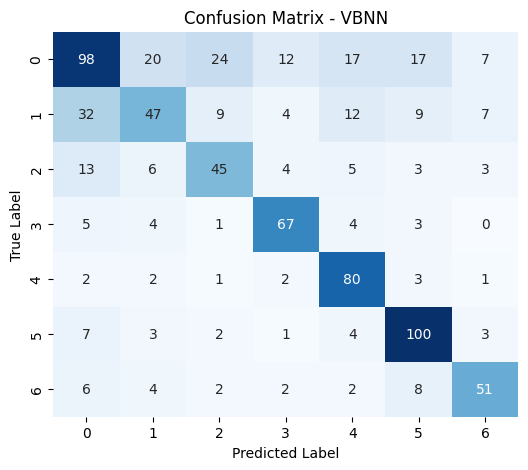

In [29]:
# Confusion Matrix
cm = confusion_matrix(y_val.values, y_pred_vbnn)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - VBNN")
plt.show()

In [30]:
# Cross-Validation 
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

f1_scores = []
acc_scores = []
pred_times = []

print("===== Cross Validation VBNN =====")

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_final, y_train), 1):
    X_tr, X_va = X_train_final.values[train_idx], X_train_final.values[val_idx]
    y_tr, y_va = y_train.values[train_idx], y_train.values[val_idx]

    model_cv = VBNN()
    model_cv.fit(X_tr, y_tr)

    start = time.time()
    y_pred = model_cv.predict(X_va)
    pred_time = time.time() - start

    f1 = f1_score(y_va, y_pred, average="macro")
    acc = accuracy_score(y_va, y_pred)

    # Simpan hasil
    f1_scores.append(f1)
    acc_scores.append(acc)
    pred_times.append(pred_time)

    # Tampilkan per fold
    print(
        f"Fold {fold:>2} | "
        f"Macro F1: {f1*100:6.2f}% | "
        f"Akurasi: {acc*100:6.2f}% | "
        f"Waktu Prediksi: {pred_time:.4f} detik"
    )

# Ringkasan
print("\n===== Ringkasan CV =====")
print(f"Macro F1 Mean : {np.mean(f1_scores)*100:.2f}%")
print(f"Macro F1 Std  : {np.std(f1_scores)*100:.2f}%")
print(f"Akurasi Mean : {np.mean(acc_scores)*100:.2f}%")
print(f"Akurasi Std  : {np.std(acc_scores)*100:.2f}%")
print(f"Avg Predict Time : {np.mean(pred_times):.4f} detik")

===== Cross Validation VBNN =====
Mendeteksi Data 18 Dimensi.
Membangun k-d Tree...
OK
Fold  1 | Macro F1:  59.36% | Akurasi:  60.56% | Waktu Prediksi: 2.5324 detik
Mendeteksi Data 18 Dimensi.
Membangun k-d Tree...
OK
Fold  2 | Macro F1:  59.87% | Akurasi:  60.23% | Waktu Prediksi: 2.6032 detik
Mendeteksi Data 18 Dimensi.
Membangun k-d Tree...
OK
Fold  3 | Macro F1:  59.98% | Akurasi:  60.72% | Waktu Prediksi: 3.1355 detik
Mendeteksi Data 18 Dimensi.
Membangun k-d Tree...
OK
Fold  4 | Macro F1:  60.19% | Akurasi:  60.98% | Waktu Prediksi: 3.0741 detik
Mendeteksi Data 18 Dimensi.
Membangun k-d Tree...
OK
Fold  5 | Macro F1:  59.02% | Akurasi:  60.00% | Waktu Prediksi: 2.6093 detik

===== Ringkasan CV =====
Macro F1 Mean : 59.68%
Macro F1 Std  : 0.43%
Akurasi Mean : 60.50%
Akurasi Std  : 0.35%
Avg Predict Time : 2.7909 detik
